<a href="https://colab.research.google.com/github/evillag/uncertainty_gan/blob/main/%5Bkaon%5D%5Bbernoulli_structured%5D_Workshop_CERN_uncertainties_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

1.   Download Rich detector dataset (from GDrive)
2.   Download [Uncertainty code](https://gitlab.com/lambda-hse/lhcb-rich-gan-uncertainty.git) from [paper]().
3.   Install dependencies.



In [1]:
!python --version
!pip install tf_keras


Python 3.10.12


In [ ]:

IN_COLAB = True

try:
  import google.colab
  !git clone https://gitlab.com/lambda-hse/lhcb-rich-gan-uncertainty.git
  !mv lhcb-rich-gan-uncertainty/experiments .
  !mv lhcb-rich-gan-uncertainty/src .
  !rm -r lhcb-rich-gan-uncertainty/
  !rm -r sample_data/
  !pip install tensorflow-addons
  !mkdir checkpoints
  !wget -O bernoulli_structured_dropout_line_test_cramer_weighted_kaon.zip https://www.dropbox.com/scl/fi/5wn0g9my5sqopjwo5nyr0/bernoulli_structured_dropout_line_test_cramer_weighted_kaon.zip\?rlkey\=0ef29mnmh1oons28mas1upmid
  !unzip bernoulli_structured_dropout_line_test_cramer_weighted_kaon.zip -d checkpoints
  !rm bernoulli_structured_dropout_line_test_cramer_weighted_kaon.zip
  !wget -O data.zip https://www.dropbox.com/scl/fi/wzsp02i63j7bl1xpks382/data.zip?rlkey=0pj4z7ufiyiotr8u9npos9h1y&dl=0
  !unzip data.zip
  !rm data.zip
except:
  IN_COLAB = False

In [3]:
import warnings
warnings.filterwarnings('ignore')

import datetime
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # suppress tf warnings

from experiments.efficiency.uncertainty_model_train import train_model
from experiments.efficiency.uncertainty_models import uncertainty_mlp
from experiments.efficiency.uncertainty_utils import (
    efficiency_bands_with_uncertainty, efficiency_momentum_with_uncertainty)
from experiments.efficiency.utils import (
    efficiency_bands, efficiency_momentum, ensemble_and_ref_model_inference,
    ensemble_and_ref_model_inference_on_bands, tf_to_numpy_dataset,
    threshold_selection)

from src.cramer_gan_trainer import CramerGANTrainer
from src.dataset import CramerGANDataset
from src.datasets.utils_rich import (get_merged_typed_dataset,
                                     parse_dataset_np, parse_example)
from src.models.gans.discriminators.fcn_disc import RICHDiscriminator
from src.models.gans.generators.fcn_gen import RichMCDropFunc

from scipy.spatial import distance
from tqdm import trange
from tqdm import tqdm

print(f'GPU available? {tf.config.list_physical_devices("GPU")}')

GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Global variables

In [4]:
# GLOBALS
PARTICLES = ['kaon']
DROPOUTS = [0.05,  0.3]
ENSEMBLES = [16,  256]
NUM_REPS = 2
SUB_SAMPLE_SIZE = .5#
THRESHOLD = 1.0

DATA_DIR = '/content/data'
CHECKPOINT_BASE = '/content/checkpoints'
CKPT_NUMBER = 'ckpt-21'

def get_checkpoint_name(particle):
  return f'bernoulli_structured_dropout_line_test_cramer_weighted_{particle}'

# Particle selection and dataset split

 Line experiment is mainly focused on testing whether the ensemble-based uncertainty is applicable for out-of-distribution data. To check this, we make train/test split as two disjoint sets. Taking the symmetry of the data after standardization, we split the data by the line $y=x$ (we consider pseudorapidity (ETA) and momentum (P) for split).

 ------
 Notes


*   Data is split based on two dimensions arbitrarily (P abd ETA)
*   Data is scaled to follow a normal distribution



- Features
  - Brunel_P
  - Brunel_ETA
  - nTracks_Brunel

- Targets:
    - RichDLLe
    - RichDLLk
    - RichDLLmu
    - RichDLLp
    - RichDLLbt

- Discarded
  - probe_sWeight

In [5]:
def _split_by_line(df, slope=1, intercept=0):
  top_half = df[df['Brunel_ETA'] > df['Brunel_P'] * slope + intercept]
  bottom_half = df[df['Brunel_ETA'] <= df['Brunel_P'] * slope + intercept]

  top_half = top_half.reset_index(drop=True)
  bottom_half = bottom_half.reset_index(drop=True)

  return top_half, bottom_half

def split_by_line(df_train, df_test):
  return _split_by_line(df_train)[0], _split_by_line(df_test)[1]

def load_particle_datasets(particle, data_dir=DATA_DIR):
  """ The returned dictionary has this format:
      {
        "<particle_name>": {
          'data_train': data_train,
          'data_val': data_val,
          'scaler': scaler,
          'feats_train': feats_train,
          'targets_train': targets_train,
          'feats_val': feats_val,
          'targets_val': targets_val
        }
      }
  """
  data_train, data_val, scaler = get_merged_typed_dataset(data_dir, particle, dtype=np.float32, log=True,
                                                          sample_fn=split_by_line)
  feats_train, targets_train, _ = parse_dataset_np(data_train)
  feats_val, targets_val, _ = parse_dataset_np(data_val)

  print(f'feats_train shape\t{feats_train.shape}\n'
        f'targets_train shape\t{targets_train.shape}\n'
        f'feats_val shape  \t{feats_val.shape}\n'
        f'targets_val shape\t{targets_val.shape}\n')

  return {
      'data_train': data_train,
      'data_val': data_val,
      'scaler': scaler,
      'feats_train': feats_train,
      'targets_train': targets_train,
      'feats_val': feats_val,
      'targets_val': targets_val
  }

datasets = {particle: load_particle_datasets(particle) for particle in PARTICLES}

Reading and concatenating datasets:
	/content/data/kaon2_+_down_2016_.csv
	/content/data/kaon2_+_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 500000
scaler n_quantiles: 100000, time = 0.8364930152893066
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>
feats_train shape	(219375, 3)
targets_train shape	(219375, 5)
feats_val shape  	(139589, 3)
targets_val shape	(139589, 5)



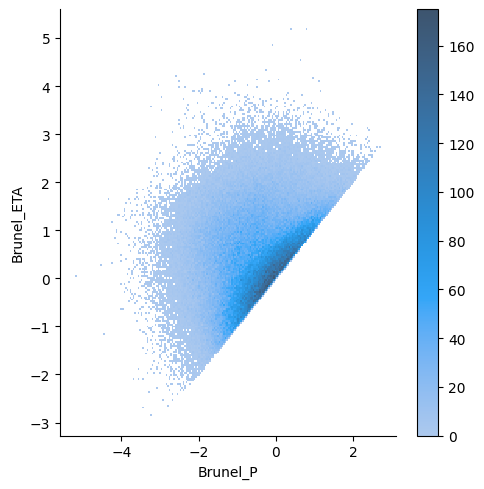

In [6]:
 sns.displot(datasets[PARTICLES[0]]['data_train'], x='Brunel_P', y='Brunel_ETA', cbar=True)

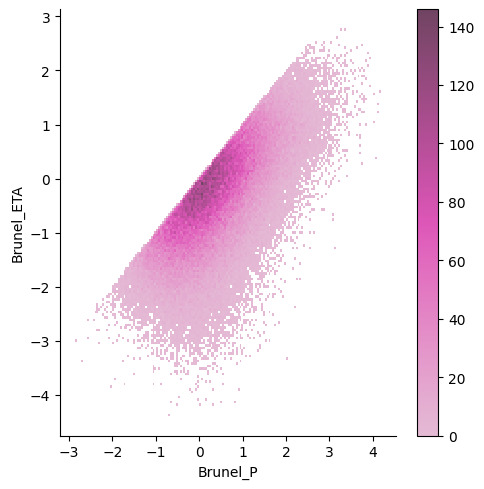

In [7]:
sns.displot(datasets[PARTICLES[0]]['data_val'], x='Brunel_P', y='Brunel_ETA', cbar=True, color='tab:pink')

# Models creation (restoring from checkpoint)

 This chapter contains the only model definition and restores the model from the checkpoint. It does not contain training/evaluation routines since it was done in another notebook (look LineTestTrain.ipynb notebook).

We use Cramer GAN modification to train generator learn the distribution. [Link](https://arxiv.org/abs/1705.10743) to Cramer GAN for more details. The training configuration:

* Batch size: 1000
* Critic steps: 15
* Generator optimizer: RMSProp with learning rate 0.0002
* iscriminator optimizer: RMSProp with learning rate 0.0002
* Use weights: True
* Number of epochs: 400

In [8]:
class MonteCarloDroupoutModel:
  def __init__(self, particle, dropout_rate,
               log_dir='log_dir_tmp',
               checkpoint_base=CHECKPOINT_BASE,
               chekpoint_file=CKPT_NUMBER,
               debug=False):

    self.particle = particle
    self.dropout_rate = dropout_rate
    self.log_dir = log_dir

    print(f'Creating model for {particle} with a dropout rate of {dropout_rate}')

    self._gen_config = {
        'drop_rate': dropout_rate,
        'dropout_type': 'bernoulli_structured',
        'drop_kwargs': {'patch_size': 3}
    }

    self._generator = RichMCDropFunc(**self._gen_config)
    self._discriminator = RICHDiscriminator()

    self._checkpoint_dir = os.path.join(checkpoint_base, get_checkpoint_name(self.particle))
    self._filename = os.path.join(self._checkpoint_dir, chekpoint_file)

    if debug:
      print("\nGenerator:\n")
      print(self._generator.summary(line_length=96))
      print("\nDiscriminator:\n")
      print(self._discriminator.summary())
      print(f"\nCheckpoint filename: {self._filename}\n")


    # Model was trained with tensorflow 2.10.1, use the legacy optimizer
    self._generator_optimizer = tf_keras.optimizers.legacy.RMSprop(2e-4)
    self._discriminator_optimizer = tf_keras.optimizers.legacy.RMSprop(2e-4)

    self._trainer_config = {
      'generator': self._generator,
      'discriminator': self._discriminator,
      'generator_optimizer': self._generator_optimizer,
      'discriminator_optimizer': self._discriminator_optimizer,
      'checkpoint_dir': self._checkpoint_dir,
      'log_dir': log_dir
    }
    trainer = CramerGANTrainer(**self._trainer_config)
    # Restore pretrained model
    trainer.restore(self._filename)

  def __str__(self):
     return f"{self.particle}_{self.dropout_rate}"

  def get_generator(self):
    return self._generator


# Test model creation
# MonteCarloDroupoutModel(PARTICLES[0], DROPOUTS[0], debug=True)

In [9]:
%%capture
# If this cell is run more than once, previous models are garbage collected and a Checkpoint warning is displayed, disregard it.
models = dict()

for particle in PARTICLES:
  for dp in DROPOUTS:
    models[f"{particle}_{dp}"] = MonteCarloDroupoutModel(particle, dp)


In [10]:
models

{'kaon_0.05': <__main__.MonteCarloDroupoutModel at 0x7c58dc10ab00>,
 'kaon_0.01': <__main__.MonteCarloDroupoutModel at 0x7c58dc254ee0>,
 'kaon_0.1': <__main__.MonteCarloDroupoutModel at 0x7c58dc0ac550>,
 'kaon_0.3': <__main__.MonteCarloDroupoutModel at 0x7c58d04f19f0>}

# Inference tests & Uncertainty estimation

## Sample sets generation
Let's start with selecting a subsample from the validation dataset.

This function will create a subsample of the input and output datasets

In [11]:
# dataset -> datasets['<particle>']['feats_val']

def subsample_dataset(features_ds, targets_ds, subsample_percent_size=1.0, debug=False):
  n = int(len(features_ds) * subsample_percent_size)
  sample_idxs = np.random.choice(np.arange(len(features_ds)), n, replace=False)
  x_sample = tf.constant(features_ds[sample_idxs])
  y_sample = tf.constant(targets_ds[sample_idxs])
  if debug:
    print(f'x_sample type = {type(x_sample)}\tshape={x_sample.shape}\n'
          f'  Brunel_P     Brunel_ETA  nTracks_Brunel\n{x_sample[:3]}\n')
    print(f'y_sample type = {type(y_sample)}\tshape={y_sample.shape}\n'
          f'  RichDLLe     RichDLLk    RichDLLmu   RichDLLp    RichDLLbt\n{y_sample[:3]}')

  return x_sample, y_sample

# test
_ = subsample_dataset(datasets[PARTICLES[0]]['feats_val'], datasets[PARTICLES[0]]['targets_val'], .1, debug=True)


x_sample type = <class 'tensorflow.python.framework.ops.EagerTensor'>	shape=(13958, 3)
  Brunel_P     Brunel_ETA  nTracks_Brunel
[[ 1.3881284  -0.42656896 -1.208143  ]
 [ 0.2114134  -1.0975776  -0.3571798 ]
 [ 0.12587737 -0.08688955  0.4296412 ]]

y_sample type = <class 'tensorflow.python.framework.ops.EagerTensor'>	shape=(13958, 5)
  RichDLLe     RichDLLk    RichDLLmu   RichDLLp    RichDLLbt
[[-0.25210872  1.7280283  -0.30998573 -1.2772378  -0.65301734]
 [ 0.9574391   1.9989842   0.6223108   0.85569143  0.81733125]
 [-0.5378155   0.29240742 -0.96991354  0.17613284  0.11716102]]


## Uncertainty estimation

Our approach to estimate uncertainty was to generate a prediction $\hat{y}$ with the model without using dropout, then for the same input $x^{(j)}$, we generated multiple predictions using different dropout ensembles of different sizes and estimated the variance of those predictions. If the ensemble prediction presents a low variance for an input, then it would appear there is low uncertainty for that observation.

To calculate the ensemble variance $\sigma_{j}^{2}$ for a given observation $x^{(j)}$, we used the following formula:

 (1)
 $$\sigma_{j}^{2}\left(\boldsymbol{x^{(j)}}\right)=\frac{1}{N-1}\sum_{i=1}^{N}\left(\bar{y}\left(\boldsymbol{x^{(j)}}\right)-y_{i}\left(\boldsymbol{x^{(j)}}\right)\right)^{2}$$

Where:
    
  *   The size of the virtual ensemble is $N$.
  *   A single input is $x^{(j)}$.
  *   A generated value for a given model in the virtual ensemble is $y_i$.
  *   The average of all predictions of the ensemble for $x^{(j)}$ is $\bar{y}$.

To evaluate the model using the validation dataset, we used
the following algorithm:

1.Perform M repetitions per each ensemble size:

  *   Generate $N$ (ensemble size) predictions for the subsample of $X^*\in X$ observations.
  *   Calculate ensemble variance using $(1)$.  
  *   Calculate the repetitions variance based on the individual variances of each repetition from the previous step.


<!-- 2.Estimate the variance of each $x^{(j)} \in X$ -> REVISAR -->

2.Estimate our uncertainty score $u$ for each $x^{(j)}$ as an average of the outputs' variance as follows:

$$u\left(\boldsymbol{x^{(j)}}\right)=\frac{1}{P}\sum_{p=1}^{P=5}\sigma_{j}^{2}\left(\boldsymbol{x^{(j)}}\right)_p$$

Where:
 * P is the set of output values, in this case each output represent the difference between a particle and a pion ($\pi$).

3.Average the residuals for each particle output $\hat{y}_p$ with the actual value $t_p$, to get an error estimate $ϵ$:

$$\epsilon\left(\boldsymbol{x}^{\left(j\right)}\right)=\frac{1}{P}\sum_{p=1}^{P=5}\left(\hat{y}\left(\boldsymbol{x^{\left(j\right)}}\right)_p-t\left(\boldsymbol{x^{\left(j\right)}}\right)_p\right)^{2}$$

4.Finally, create two sets of uncertainties, one for the correct predictions, another one for the incorrect ones, defined as $\varphi$ as follows:

$$\varphi\left(\boldsymbol{x}^{\left(j\right)}\right)=\begin{cases}
u\left(\boldsymbol{x}^{\left(j\right)}\right)\in U_{\textrm{correct}} & \textrm{if }\epsilon\left(\boldsymbol{x}^{\left(j\right)}\right)<\tau\\
u\left(\boldsymbol{x}^{\left(j\right)}\right)\in U_{\textrm{incorrect}} & \textrm{otherwise}
\end{cases}$$

Where:

 *  A threshold $\tau$ is defined so that if $\epsilon$ is under the threshold, the prediction will be considered as correct.


In [12]:
def _downsize(a, b):
  # downsize to match the wrong predictions
  selected_indices = np.random.choice(np.arange(len(a)), len(b), replace=False)
  new_a = tf.gather(a, selected_indices)
  return new_a, b


def downsize(a, b):
  if tf.rank(a).numpy() == 0:
    return a, b[0]
  elif tf.rank(b).numpy() == 0:
    return a[0], b
  elif len(a) == len(b):
    return a, b
  elif len(a) < len(b):
    new_b, a = _downsize(b, a)
    return a, new_b
  return _downsize(a, b)


def phi(uncertainty_score, epsilon, threshold=1.0, downsize_larger_set=True, debug=False):

  u_correct_all = tf.squeeze(tf.where(epsilon < threshold, uncertainty_score, tf.zeros(epsilon.shape)))
  correct_indices = tf.squeeze(tf.where(u_correct_all))
  u_correct_all = tf.gather(u_correct_all, correct_indices)

  u_incorrect_all = tf.squeeze(tf.where(epsilon >= threshold, uncertainty_score, tf.zeros(epsilon.shape)))
  incorrect_indices = tf.squeeze(tf.where(u_incorrect_all))
  u_incorrect_all = tf.gather(u_incorrect_all, incorrect_indices)

  u_correct, u_incorrect = u_correct_all, u_incorrect_all
  if downsize_larger_set:
    u_correct, u_incorrect = downsize(u_correct_all, u_incorrect_all)

  if debug:
    print(f'Processing ensemble with threshold {threshold}')
    print(f'correct_idxs\t{len(correct_indices)}')
    print(f'incorrect_idxs\t{len(incorrect_indices)}')
    print(f'Downsized U_correct size={len(u_correct)}')
    print(f'Downsized U_incorrect size={len(u_incorrect)}\n----------')

  return len(u_correct_all), len(u_incorrect_all), u_correct.numpy(), u_incorrect.numpy()


def measure_js_distance(set1, set2, n_bins=50):
  if set1.size > 0 or set2.size > 0:
    p = np.histogram(set1,bins=n_bins)[0] / len(set1)
    q = np.histogram(set2,bins=n_bins)[0] / len(set2)
    return distance.jensenshannon(p, q)
  return 0.0


def parse_model_name(model_name):
  """Splits the model name into its parts: particle and dropout"""
  name_split = model_name.split('_')
  particle = name_split[0]
  dropout = name_split[1]
  return particle, dropout


In [16]:
def run_experiments(all_models, all_datasets, random_seed=20230829, save_u_sets=False):
  distances_df = {
    'particle': [],
    'dropout': [],
    'Ensemble size': [],
    'js_distance': [],
    'js_distance_std': [],
    'correct_count': [],
    'correct_count_std': [],
    'incorrect_count': [],
    'incorrect_count_std': []
  }

  u_sets = dict()

  if random_seed != -1:
    tf_keras.utils.set_random_seed(random_seed)

  for name, model in all_models.items():
    particle, dropout = parse_model_name(name)
    generator = model.get_generator()
    generator.ensemble_inference_mode()
    reference_model = MonteCarloDroupoutModel(particle, float(dropout))
    reference_generator = reference_model.get_generator()
    reference_generator.predict_mode()
    ensemble_inferences = dict()

    print(f"Generating predictions with model for particle {particle.upper()} and dropout {dropout}")
    for ensemble_size in tqdm(ENSEMBLES):
      distances = []
      correct_preds_cnt = []
      incorrect_preds_cnt = []

      # Step 1: Perform M repetitions per each ensemble
      for rep in range(NUM_REPS):
        try:
          # draw a sample from the validation datasets
          x_sample, y_sample = subsample_dataset(all_datasets[particle]['feats_val'],
                                                 all_datasets[particle]['targets_val'],
                                                 SUB_SAMPLE_SIZE)
          # estimate reference prediction
          reference_predicted_value = reference_generator(x_sample)

          prediction_list = []
          for inference in range(ensemble_size):
            prediction_list.append(generator(x_sample))

          predicted_values = tf.convert_to_tensor(prediction_list)
          ensemble_variance = tf.math.reduce_variance(predicted_values, 0)

          # step 2: Estimate our uncertainty score u for each x(j) as an average of the outputs’ variance
          uncertainty_score =  tf.expand_dims(tf.math.reduce_mean(ensemble_variance, 1), 1)

          # step 3: Average the residuals of each particle reference output with the actual value
          squared_residual = (reference_predicted_value - y_sample) ** 2
          epsilon =  tf.expand_dims(tf.math.reduce_mean(squared_residual, 1), 1)

          # step 4: Classify correct and incorrect predictions
          u_correct_all_cnt, u_incorrect_all_cnt, u_correct, u_incorrect = phi(uncertainty_score, epsilon, THRESHOLD)

          # Estimate Jensen-Shannon distance between sets
          jsd_metric = measure_js_distance(u_correct, u_incorrect)
          distances.append(jsd_metric)
          correct_preds_cnt.append(u_correct_all_cnt)
          incorrect_preds_cnt.append(u_incorrect_all_cnt)
          if save_u_sets:
            u_sets[f'{particle}_{dropout}__{ensemble_size}_{rep}'] = {
                'u_correct': u_correct,
                'u_incorrect': u_incorrect
            }
        except Exception as error:
          print(f'Error processing {particle} at droupout {dropout}: {error}')

      # Aggregate results
      distances_np = np.array(distances, dtype=float)
      distances_df['particle'].append(particle)
      distances_df['dropout'].append(dropout)
      distances_df['Ensemble size'].append(ensemble_size)
      distances_df['js_distance'].append(distances_np.mean())
      distances_df['js_distance_std'].append(distances_np.std())
      correct_np = np.array(correct_preds_cnt, dtype=int)
      incorrect_np = np.array(incorrect_preds_cnt, dtype=int)
      distances_df['correct_count'].append(np.median(correct_np))
      distances_df['correct_count_std'].append(correct_np.std())
      distances_df['incorrect_count'].append(np.median(incorrect_np))
      distances_df['incorrect_count_std'].append(incorrect_np.std())

  return pd.DataFrame(distances_df), u_sets


#### Models execution

In [17]:
%%time
jsd_df, u_sets = run_experiments(models, datasets, save_u_sets=True)

Creating model for kaon with a dropout rate of 0.05
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
0.001
Generating predictions with model for particle KAON and dropout 0.05


100%|██████████| 5/5 [00:31<00:00,  6.20s/it]


Creating model for kaon with a dropout rate of 0.01
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
0.001
Generating predictions with model for particle KAON and dropout 0.01


100%|██████████| 5/5 [00:32<00:00,  6.45s/it]


Creating model for kaon with a dropout rate of 0.1
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
0.001
Generating predictions with model for particle KAON and dropout 0.1


100%|██████████| 5/5 [00:32<00:00,  6.59s/it]


Creating model for kaon with a dropout rate of 0.3
Layer 0
Layer 1
Layer 2
Layer 3
Layer 4
0.001
Generating predictions with model for particle KAON and dropout 0.3


100%|██████████| 5/5 [00:31<00:00,  6.21s/it]

CPU times: user 2min 7s, sys: 2.17 s, total: 2min 9s
Wall time: 2min 8s


In [18]:
display(jsd_df)

,particle,dropout,Ensemble size,js_distance,js_distance_std,correct_count,correct_count_std,incorrect_count,incorrect_count_std
0,kaon,0.05,16,0.082087,0.029691,34866.5,135.5,34927.5,135.5
1,kaon,0.05,32,0.063443,0.000080,35085.5,102.5,34708.5,102.5
2,kaon,0.05,64,0.082923,0.003878,34819.0,27.0,34975.0,27.0
3,kaon,0.05,128,0.113920,0.004281,34818.5,89.5,34975.5,89.5
4,kaon,0.05,256,0.127944,0.033099,34975.5,166.5,34818.5,166.5
5,kaon,0.01,16,0.104371,0.009503,38897.0,93.0,30897.0,93.0
6,kaon,0.01,32,0.131686,0.011854,38887.0,22.0,30907.0,22.0
7,kaon,0.01,64,0.156344,0.013032,39057.0,59.0,30737.0,59.0
8,kaon,0.01,128,0.163936,0.020372,38859.5,148.5,30934.5,148.5
9,kaon,0.01,256,0.152573,0.004993,38926.5,4.5,30867.5,4.5


In [19]:
from datetime import datetime
# Format the date and time as a string in "YYYY_MM_DD_HH_MM_SS" format
filename = f'{DATA_DIR}/../js_distance_{"-".join(PARTICLES)}_reps_{NUM_REPS}_{datetime.now().strftime("%Y-%m-%d_%H%M%S")}.csv'
jsd_df.to_csv(filename)  # save data frame
# jsd_df = pd.read_csv(filename)   # restore data frame

# Plot results

In [20]:
def plot_results(df, particle_name, custom_ticks=None, override_title=None,
                 save_plots=False, save_path=f'{DATA_DIR}/../plots', export_file_format='pdf'):
  plt.style.use("ggplot")

  # Create a wider figure and axis
  fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize parameter as needed

  # Group the DataFrame by 'category' column
  grouped = df.groupby('Ensemble size')

  # Loop through each group and plot the lines with different colors
  for category, group_data in grouped:
      line = ax.plot(group_data['dropout'], group_data['js_distance'], linestyle=':', linewidth=0.5)
      ax.scatter(group_data['dropout'], group_data['js_distance'], marker='o', label=category)  # Add circles

      # Get the color of the line
      line_color = line[0].get_color()

      # Plot whiskers using error bars with wedges
      ax.errorbar(
        group_data['dropout'],
        group_data['js_distance'],
        yerr=group_data['js_distance_std'],
        fmt='none',
        color=line_color,
        capsize=4,
        elinewidth=0.5,
        capthick=1
      )

  # Set labels and title
  ax.set_xlabel('Dropout value')
  ax.set_ylabel('Mean Jensen-Shannon Distance')
  ax.set_title(f'{particle_name.upper()} - Distance between high and low uncertainty distributions\n'
               'of data generated with Monte Carlo dropout virtual ensembles')
  if override_title is not None:
    ax.set_title(override_title)

  # Set custom x-axis ticks
  if custom_ticks is not None:
    custom_ticks = custom_ticks
    ax.set_xticks(custom_ticks)

  # Add legend
  ax.legend(title='Ensemble Size')

  # Caption
  txt=f"Error bars represent the s.d. over {NUM_REPS} executions of the ensembles."
  plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)

  # Show the plot
  if save_plots:
    # tikzplotlib.clean_figure()
    # tikzplotlib.save(f'{save_path}/{particle}.tex')
    import matplotlib
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })
    plt.savefig(f'{save_path}/{particle}.{export_file_format}')
  else:
    plt.show()


## Jensen-Shannon distance between high and low uncertainty distributions

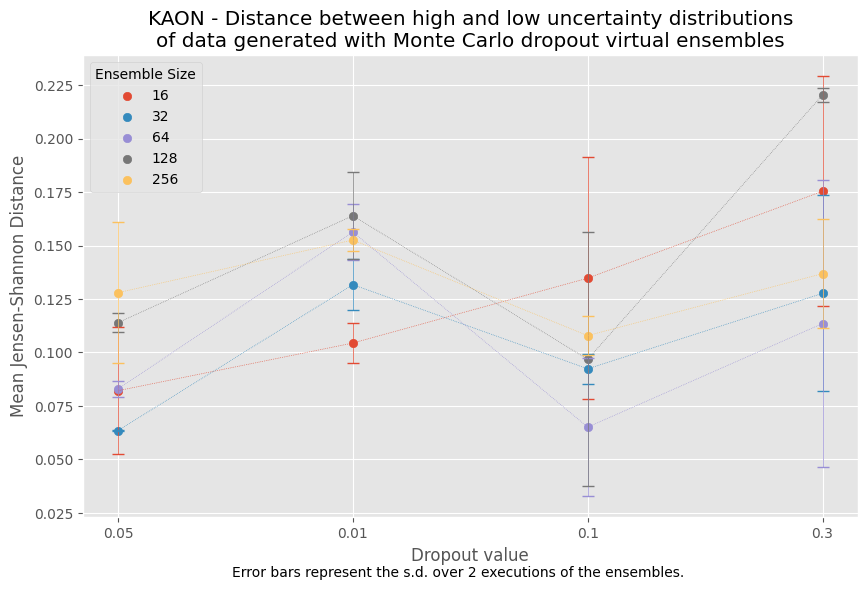

In [21]:
for particle in PARTICLES:
  plot_results(jsd_df[(jsd_df['particle'] == particle)], particle)

##Histograms

In [22]:
from numpy.lib.function_base import kaiser
def plot_histograms(predictions, n_bins=50):
  plt.style.use("ggplot")
  for k, v in predictions.items():
    density, bins = np.histogram(v['u_correct'], bins=n_bins, density=True)
    unity_density = density / density.sum()

    fig, ax3 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,4))
    widths = bins[:-1] - bins[1:]
    ax3.bar(bins[1:], unity_density, width=widths,  fill = False, edgecolor='blue')

    density, bins = np.histogram(v['u_incorrect'], bins=n_bins, density=True)
    unity_density = density / density.sum()
    ax3.bar(bins[1:], unity_density, width=widths, fill = False, edgecolor='orange') # PDF
    # ax3.bar(bins[1:], unity_density.cumsum(), width=widths) # CDF
    # ax3.set_xlabel('CDFs')

    name_parts = k.split('_')
    particle = name_parts[0]
    dp = name_parts[1]
    ensemble_size = name_parts[2]
    print(f'******{k}*******')
    ax3.set_ylabel(f'Probability density')
    ax3.set_xlabel(f'Uncertainty measure of ensemble {ensemble_size} for {particle} with dropout of {dp}')
    # ax3.set_title(f'Uncertainty classified sets')
    # Add legend
    ax3.legend(['Correct', 'Incorrect'])


    fig.tight_layout()
    plt.show()
    plt.close(fig)

******kaon_0.05__16_0*******


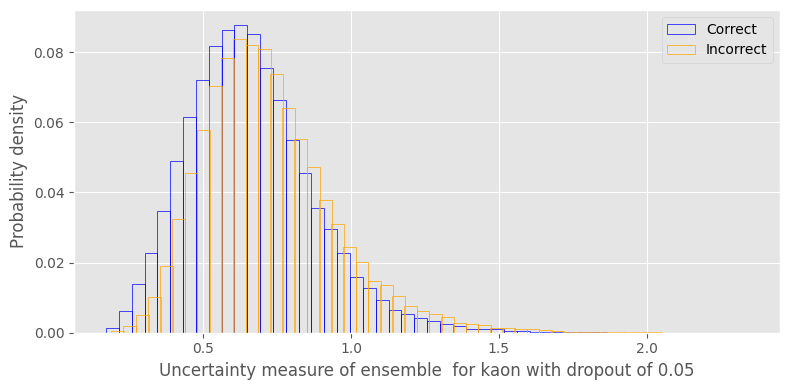

******kaon_0.05__16_1*******


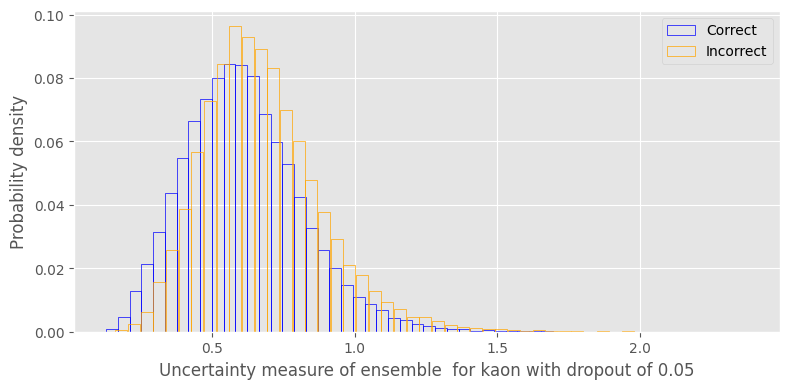

******kaon_0.05__32_0*******


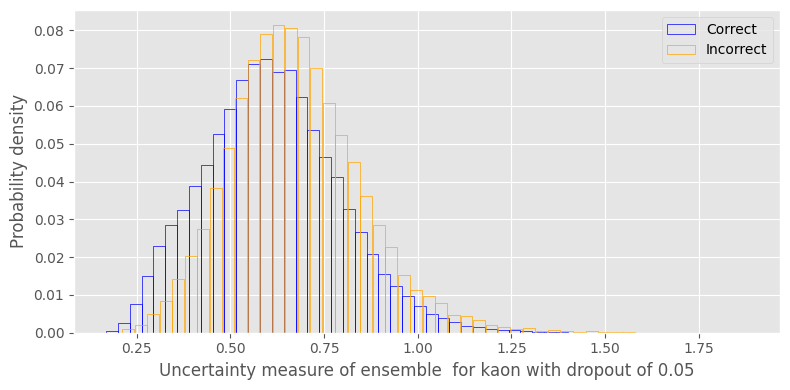

******kaon_0.05__32_1*******


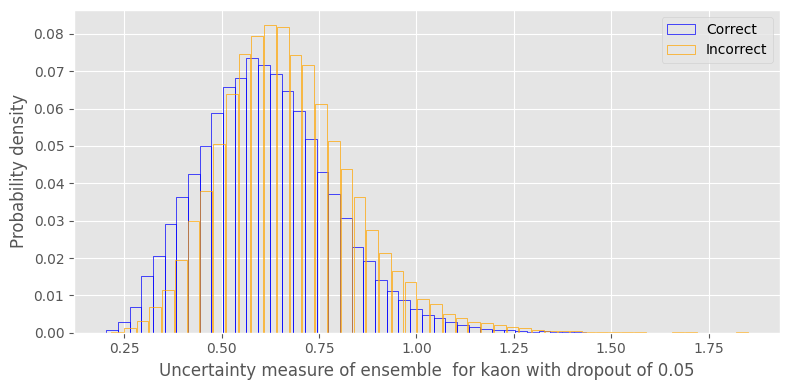

******kaon_0.05__64_0*******


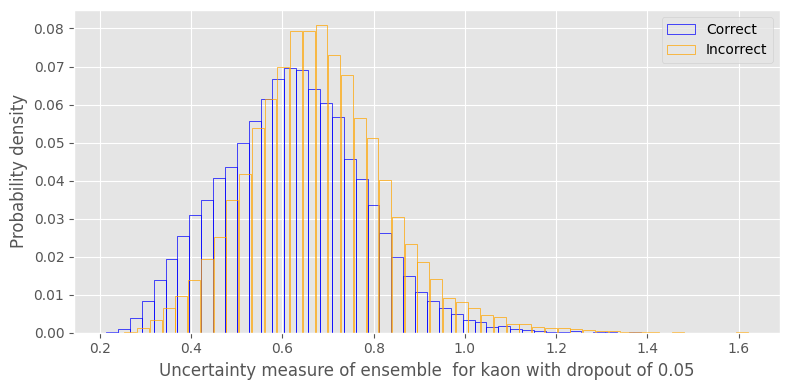

******kaon_0.05__64_1*******


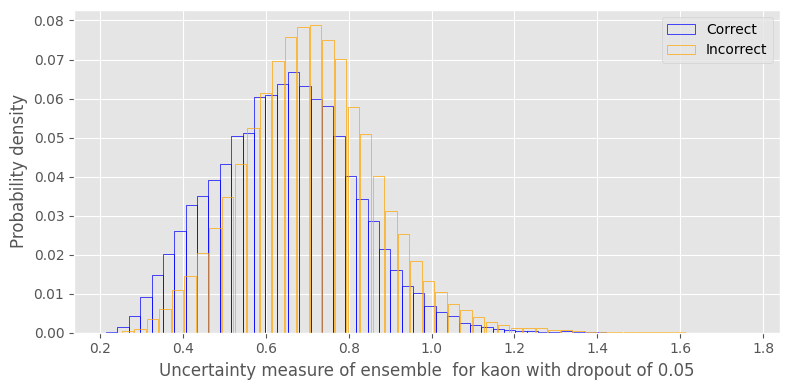

******kaon_0.05__128_0*******


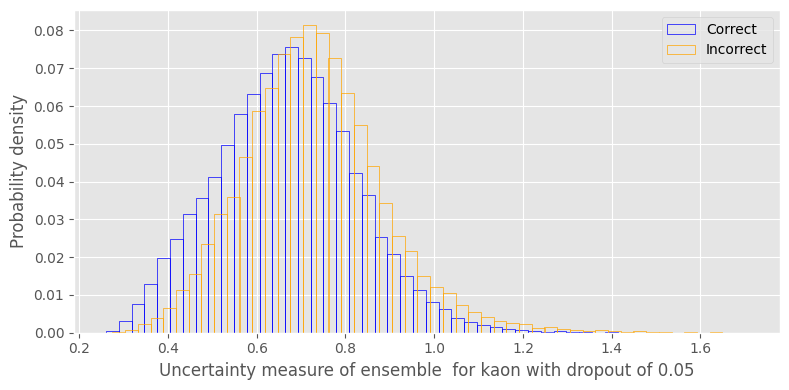

******kaon_0.05__128_1*******


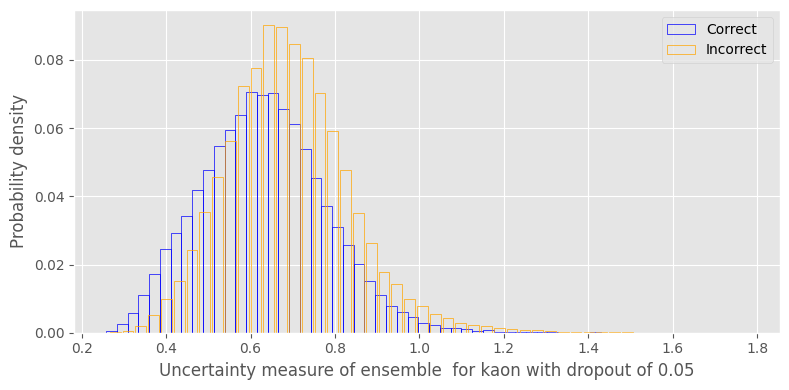

******kaon_0.05__256_0*******


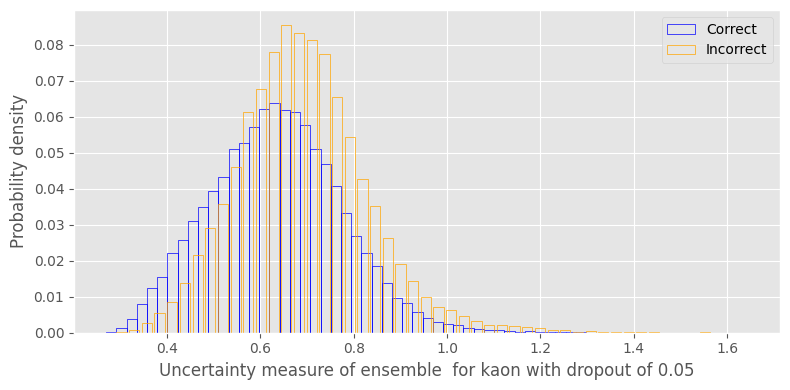

******kaon_0.05__256_1*******


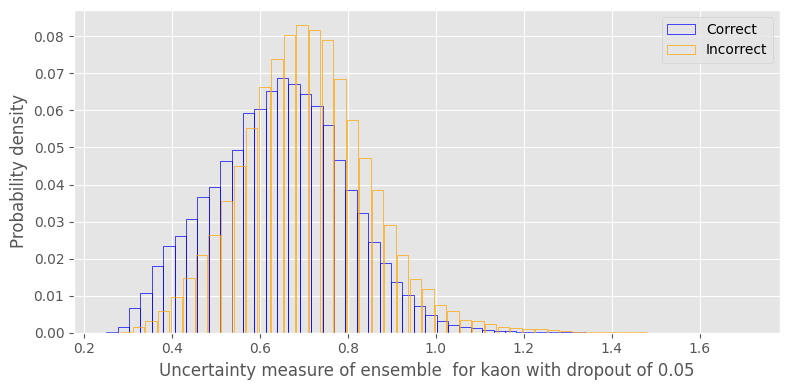

******kaon_0.01__16_0*******


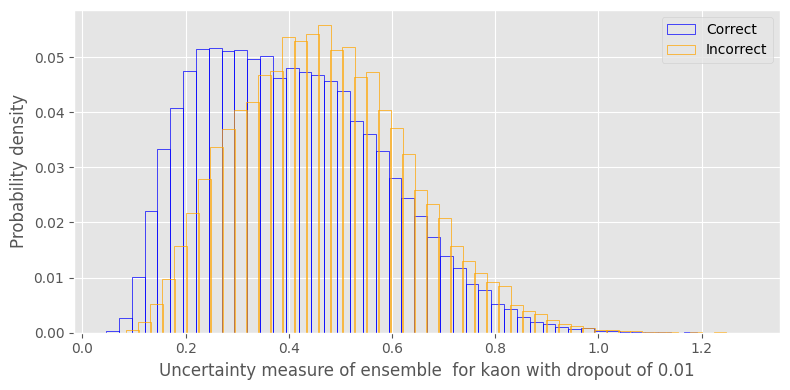

******kaon_0.01__16_1*******


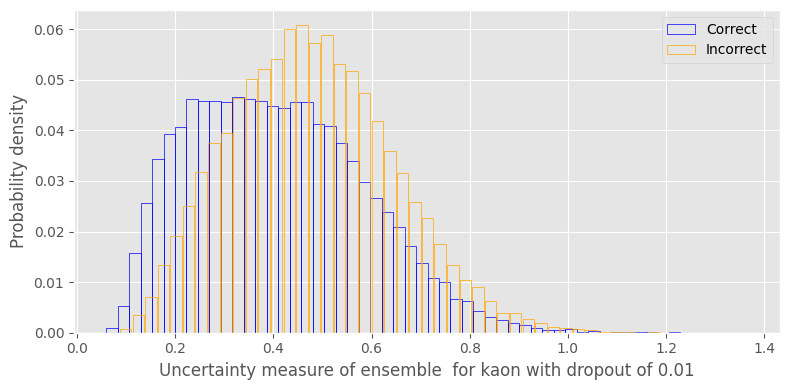

******kaon_0.01__32_0*******


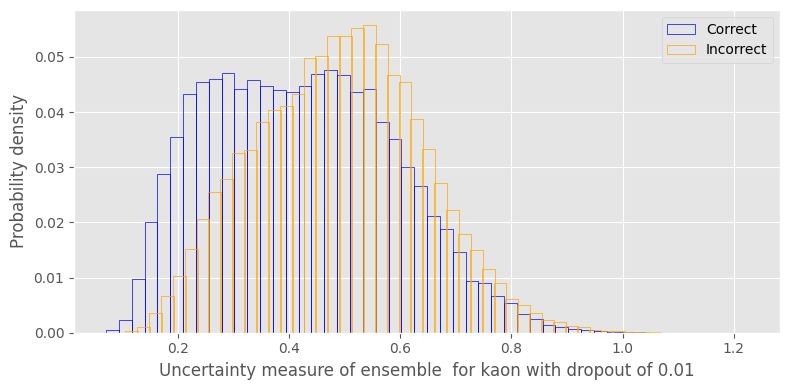

******kaon_0.01__32_1*******


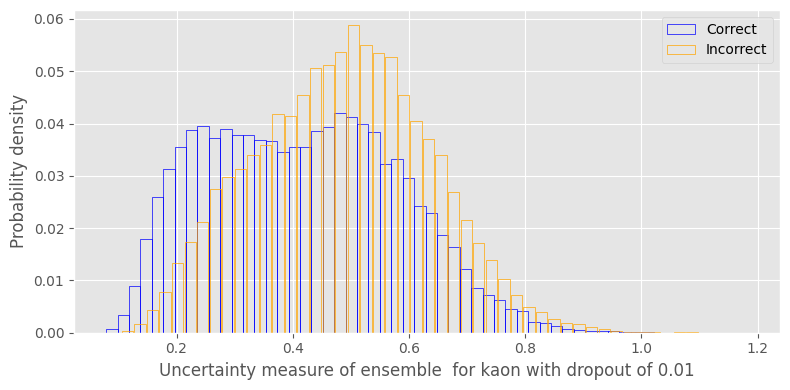

******kaon_0.01__64_0*******


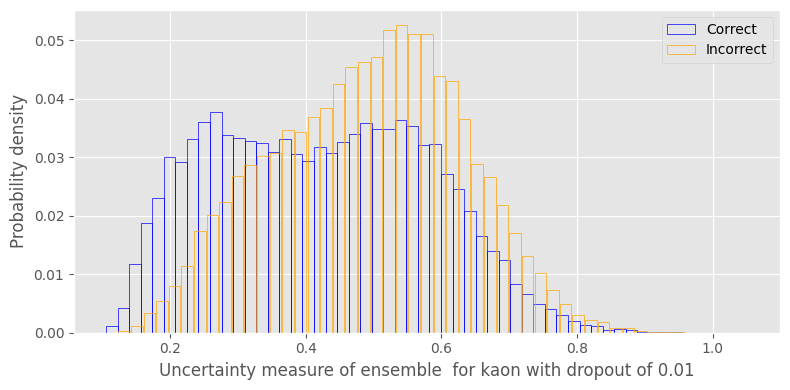

******kaon_0.01__64_1*******


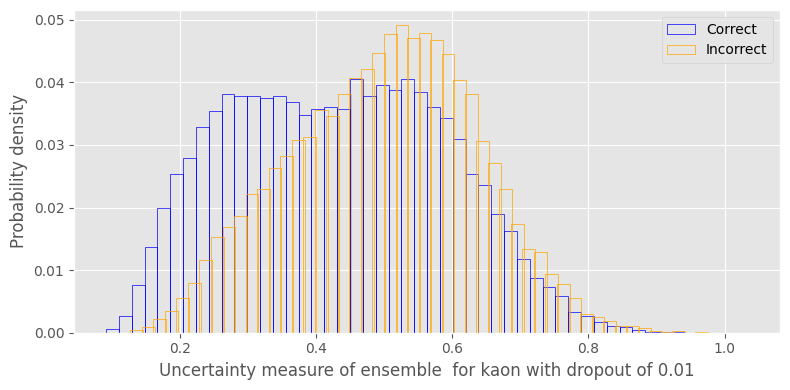

******kaon_0.01__128_0*******


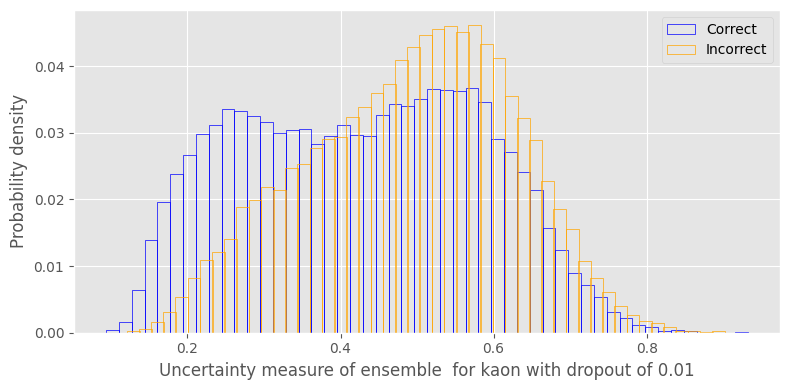

******kaon_0.01__128_1*******


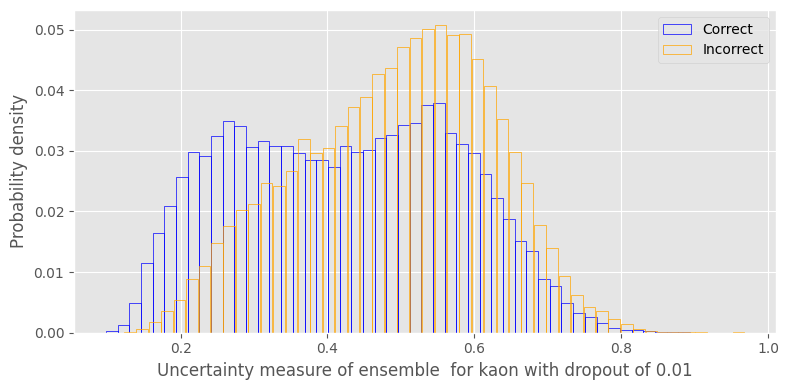

******kaon_0.01__256_0*******


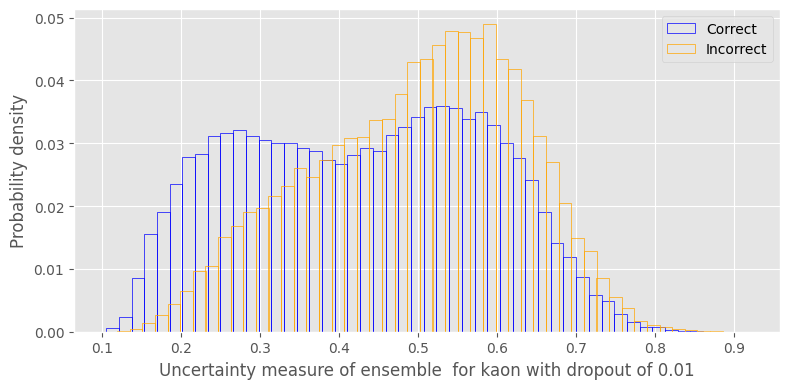

******kaon_0.01__256_1*******


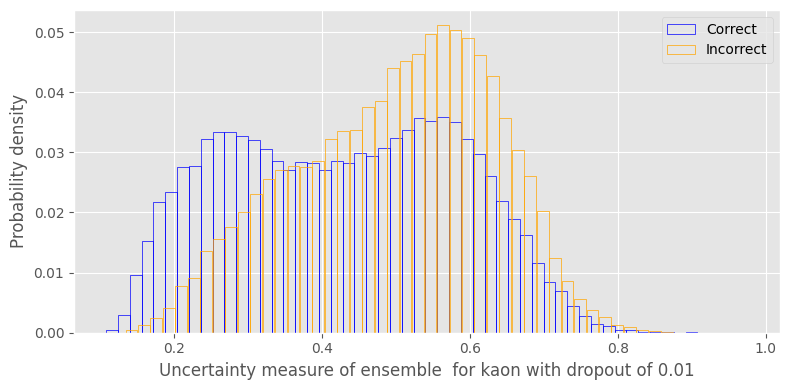

******kaon_0.1__16_0*******


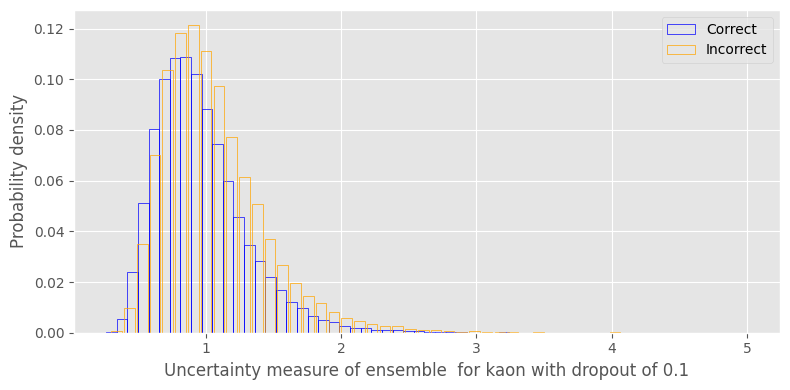

******kaon_0.1__16_1*******


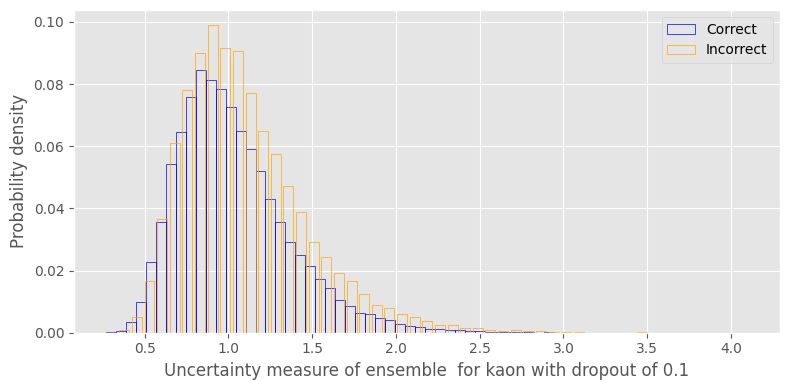

******kaon_0.1__32_0*******


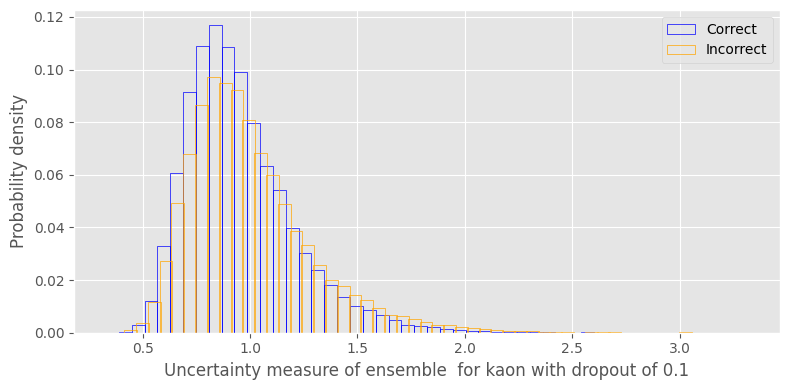

******kaon_0.1__32_1*******


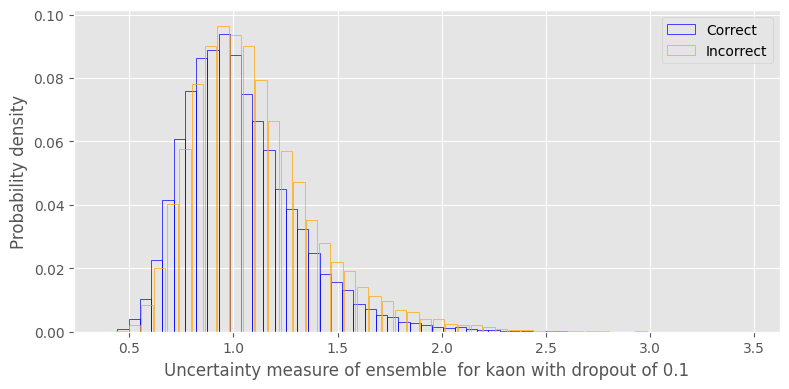

******kaon_0.1__64_0*******


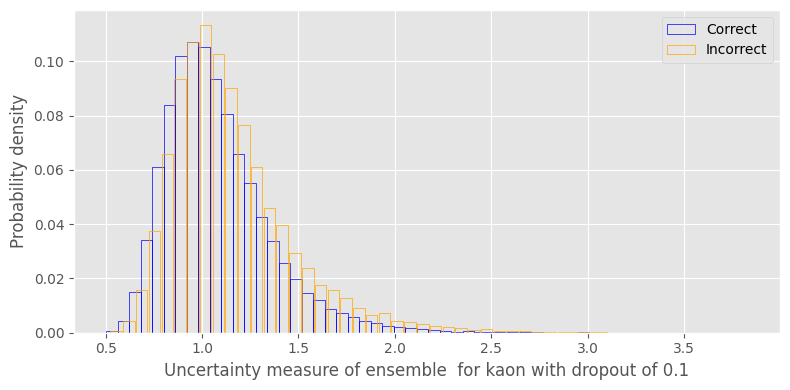

******kaon_0.1__64_1*******


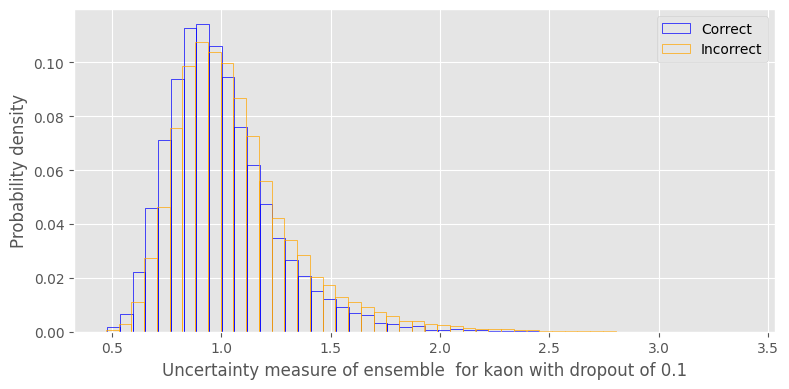

******kaon_0.1__128_0*******


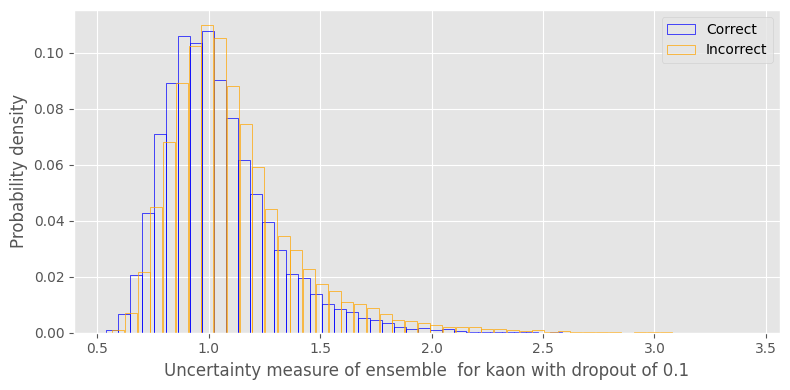

******kaon_0.1__128_1*******


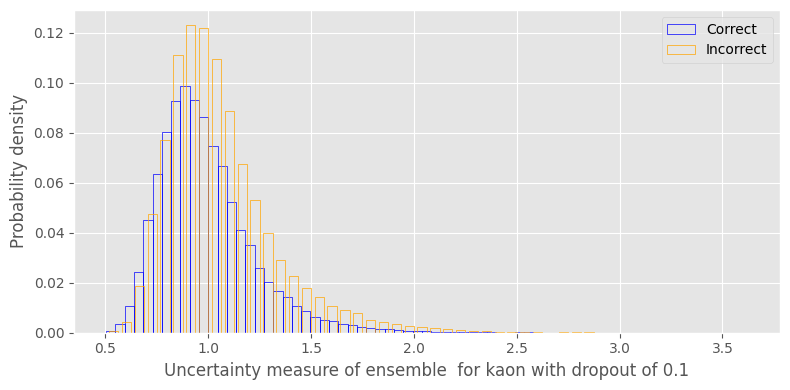

******kaon_0.1__256_0*******


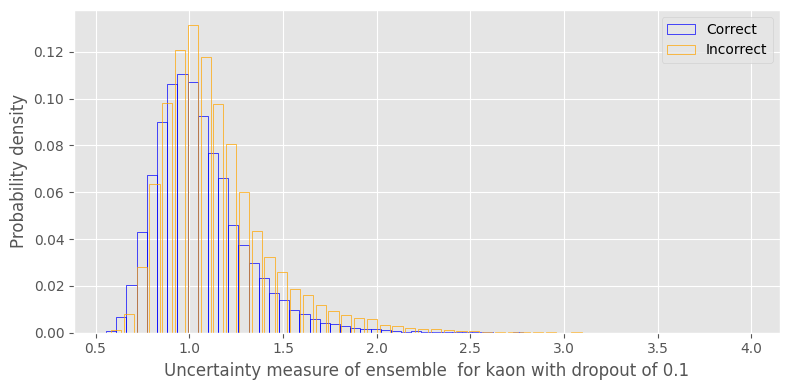

******kaon_0.1__256_1*******


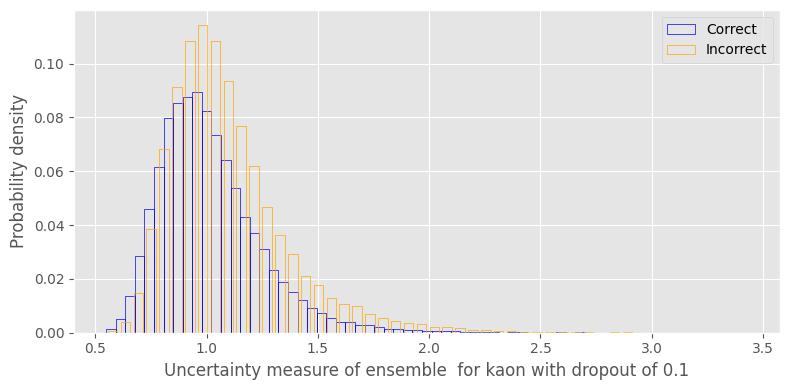

******kaon_0.3__16_0*******


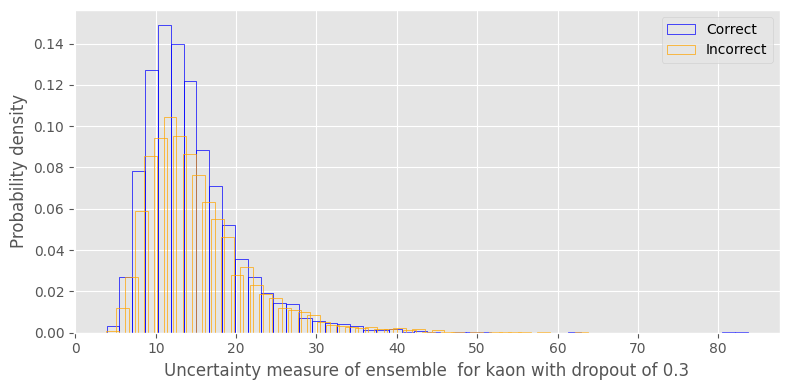

******kaon_0.3__16_1*******


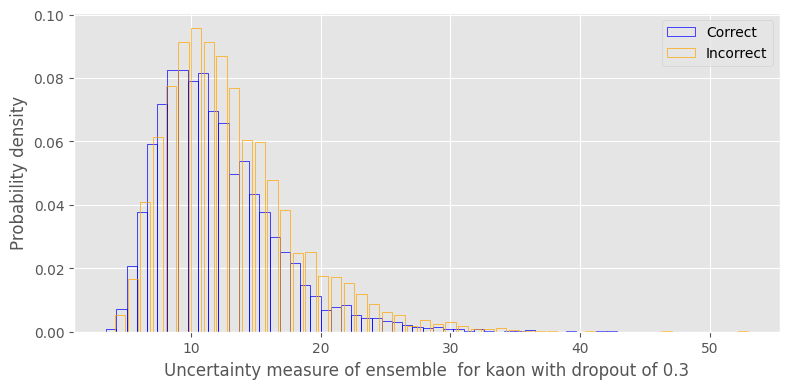

******kaon_0.3__32_0*******


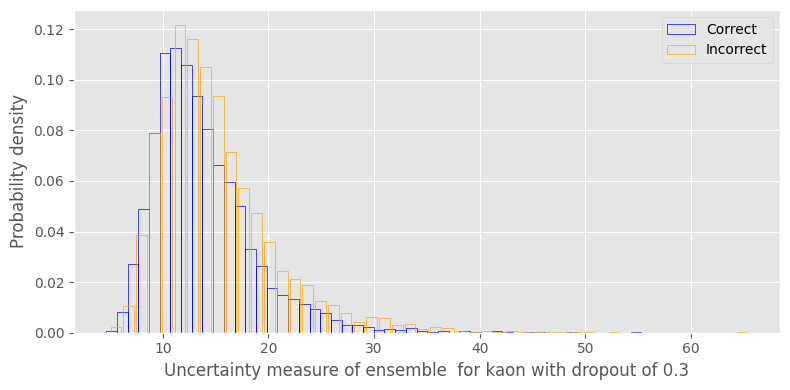

******kaon_0.3__32_1*******


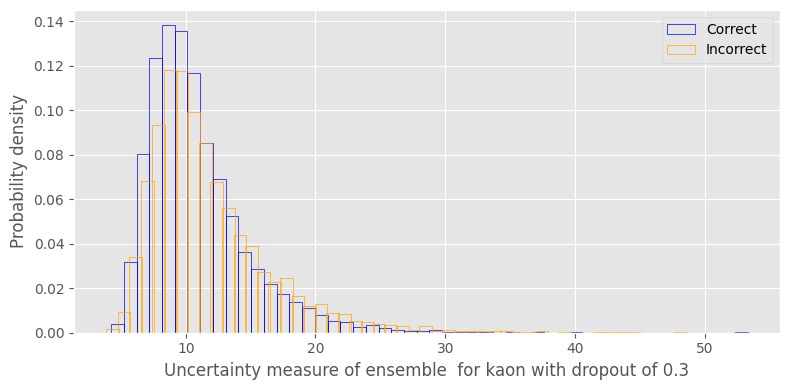

******kaon_0.3__64_0*******


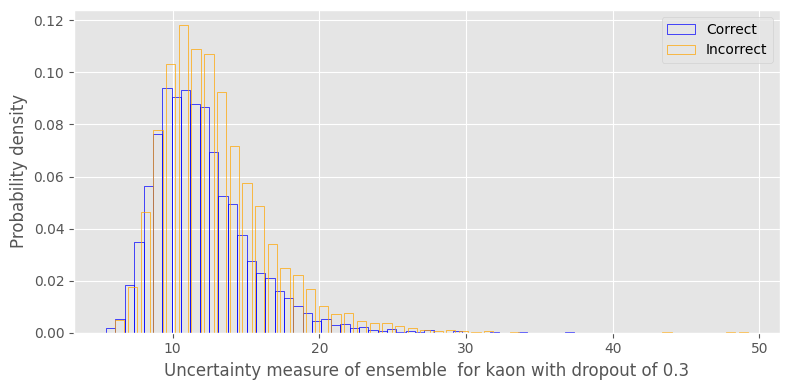

******kaon_0.3__64_1*******


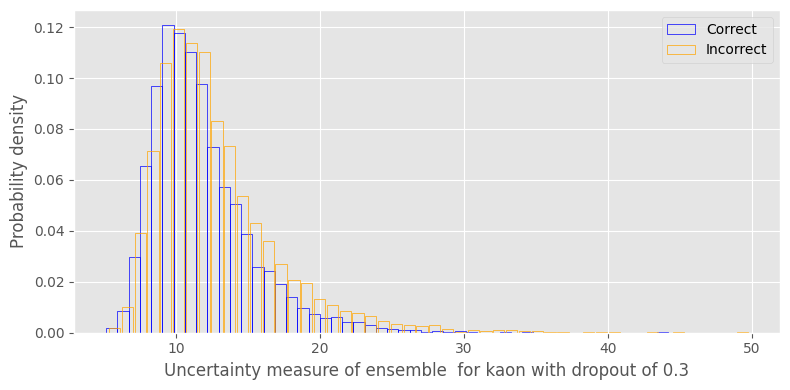

******kaon_0.3__128_0*******


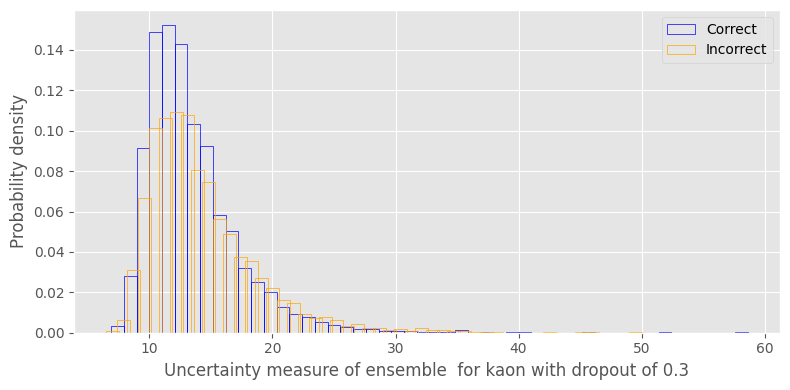

******kaon_0.3__128_1*******


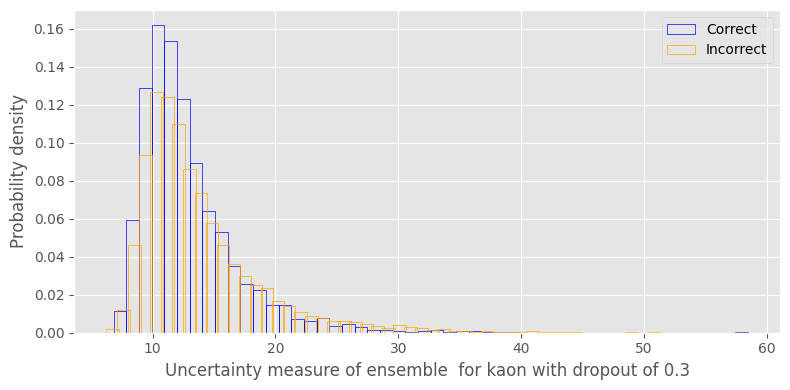

******kaon_0.3__256_0*******


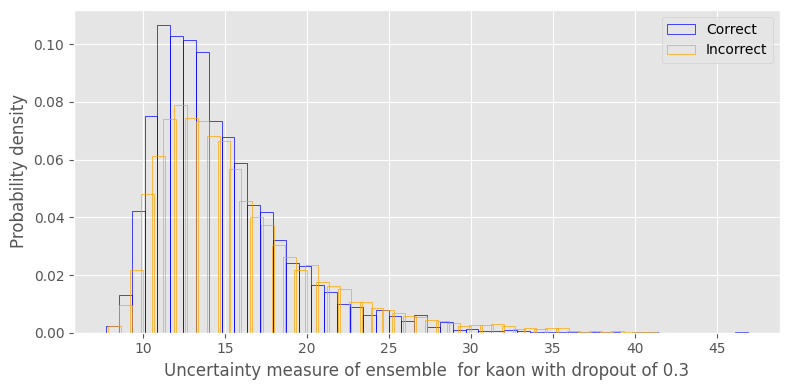

******kaon_0.3__256_1*******


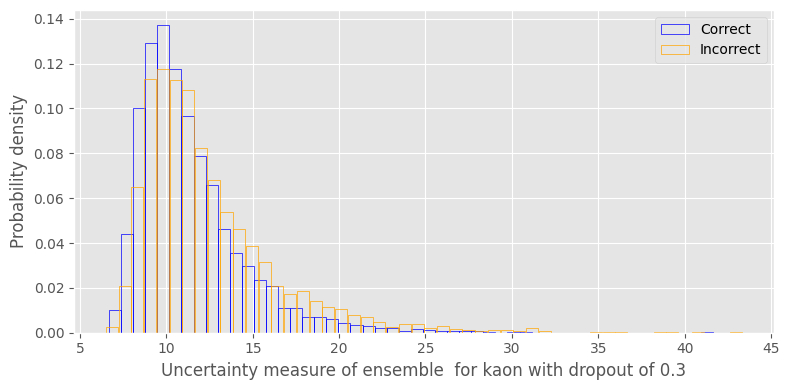

In [23]:
plot_histograms(u_sets)

__________________

## Export plots

In [24]:
# if IN_COLAB:
#   !pip install tikzplotlib folium pdflatex
#   !sudo apt-get install texlive-latex-recommended
#   !sudo apt install texlive-latex-extra
#   !sudo apt install dvipng

In [25]:
# filename = f'{DATA_DIR}/../js_distance_reps_10_2023-08-28_060340.csv'
# jsd_df = pd.read_csv(filename)   # restore data frame
# display(jsd_df)

In [26]:
# for particle in PARTICLES:
#   plot_results(jsd_df[(jsd_df['particle'] == particle)], particle, save_plots=True)

# Misc: Runtime termination

In [27]:
# Terminate runtime when done (If running in Google Colab)
# if IN_COLAB:
#   print("Bye bye.")
#   from google.colab import runtime
#   runtime.unassign()